<small><font color=gray>Notebook author: <a href="https://www.linkedin.com/in/olegmelnikov/" target="_blank">Oleg Melnikov</a> , <a href="https://www.hse.ru/en/staff/sara/" target="_blank">Saraa Ali</a> ©2025</font></small><hr style="margin:0;background-color:silver">

**[<font size=6>🌌Stellar</font>](https://www.kaggle.com/t/70dd27df0139454ab934bf3ee1d30eb1)**. [**Instructions**](https://colab.research.google.com/drive/1owkYjuRGkx050LQnM3b3yTzd0Dr2XbeV) for running Colabs.

<small>**(Optional) CONSENT.** <mark>[ X ]</mark> We consent to sharing our Colab (after the assignment ends) with other students/instructors for educational purposes. We understand that sharing is optional and this decision will not affect our grade in any way. <font color=gray><i>(If ok with sharing your Colab for educational purposes, leave "X" in the check box.)</i></font></small>

In [1]:
from google.colab import drive; drive.mount('/content/drive')   # OK to enable, if your kaggle.json is stored in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  # upgrade kaggle package (to avoid a warning)
!mkdir -p ~/.kaggle                                           # .kaggle folder must contain kaggle.json for kaggle executable to properly authenticate you to Kaggle.com
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/  # First, download kaggle.json from kaggle.com (in Account page) and place it in the root of mounted Google Drive
#!cp kaggle.json ~/.kaggle/kaggle.json > log                   # Alternative location of kaggle.json (without a connection to Google Drive)
!chmod 600 ~/.kaggle/kaggle.json                      # give only the owner full read/write access to kaggle.json
!kaggle config set -n competition -v  25-hse-stellar       # set the competition context for the next few kaggle API calls. !kaggle config view - shows current settings
!kaggle competitions download >> log                          # download competition dataset as a zip file
!unzip -o *.zip >> log                                        # Kaggle dataset is copied as a single file and needs to be unzipped.
lb =!kaggle competitions leaderboard --show                   # print public leaderboard

- competition is now set to: 25-hse-stellar


In [3]:
%%time
%%capture
%reset -f
from IPython.core.interactiveshell import InteractiveShell as IS; IS.ast_node_interactivity = "all"
import numpy as np, pandas as pd, time, matplotlib.pyplot as plt, seaborn as sns, os, tqdm, re, sys, cv2, skimage
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA, LinearDiscriminantAnalysis as LDA
ToCSV = lambda df, fname: df.round(2).to_csv(f'{fname}.csv', index_label='id') # rounds values to 2 decimals

class Timer():
  def __init__(self, lim:'RunTimeLimit'=60): self.t0, self.lim, _ = time.time(), lim, print(f'⏳ started. You have {lim} sec. Good luck!')
  def ShowTime(self):
    msg = f'Runtime is {time.time()-self.t0:.0f} sec'
    print(f'\033[91m\033[1m' + msg + f' > {self.lim} sec limit!!!\033[0m' if (time.time()-self.t0-1) > self.lim else msg)

np.set_printoptions(linewidth=100, precision=2, edgeitems=2, suppress=True)
pd.set_option('display.max_columns', 20, 'display.precision', 2, 'display.max_rows', 4)

CPU times: user 2.01 s, sys: 199 ms, total: 2.21 s
Wall time: 3.22 s


In [4]:
df = pd.read_csv('XY_Stellar.csv'); df

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,redshift,plate,MJD,fiber_ID,Class
0,11.64,21.28,26.28,26.15,24.05,18.87,19.00,8848,5,272,0.84,7740,56824,833,NaN
1,173.09,42.21,22.51,22.83,22.21,19.55,19.96,4156,3,486,0.81,9041,58067,428,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199998,131.31,44.27,24.07,24.64,21.63,19.20,19.03,7076,3,251,0.55,6014,56166,1021,G
199999,22.59,0.25,25.30,25.56,24.09,19.41,19.96,5164,4,511,1.26,9590,57969,878,G


In [5]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     200000 non-null  float64
 1   delta     200000 non-null  float64
 2   u         200000 non-null  float64
 3   g         200000 non-null  float64
 4   r         200000 non-null  float64
 5   i         200000 non-null  float64
 6   z         200000 non-null  float64
 7   run_ID    200000 non-null  int64  
 8   cam_col   200000 non-null  int64  
 9   field_ID  200000 non-null  int64  
 10  redshift  200000 non-null  float64
 11  plate     200000 non-null  int64  
 12  MJD       200000 non-null  int64  
 13  fiber_ID  200000 non-null  int64  
 14  Class     160000 non-null  object 
dtypes: float64(8), int64(6), object(1)
memory usage: 22.9+ MB


In [6]:
# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
# df.Class = df.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None)

In [7]:
vX = df.query('Class!=Class').drop('Class', axis=1)  # slice a test sample
tXY = df.query('Class==Class')                       # slice training sample
tX, tY = tXY.drop('Class', axis=1), tXY.Class        # split into training I/O

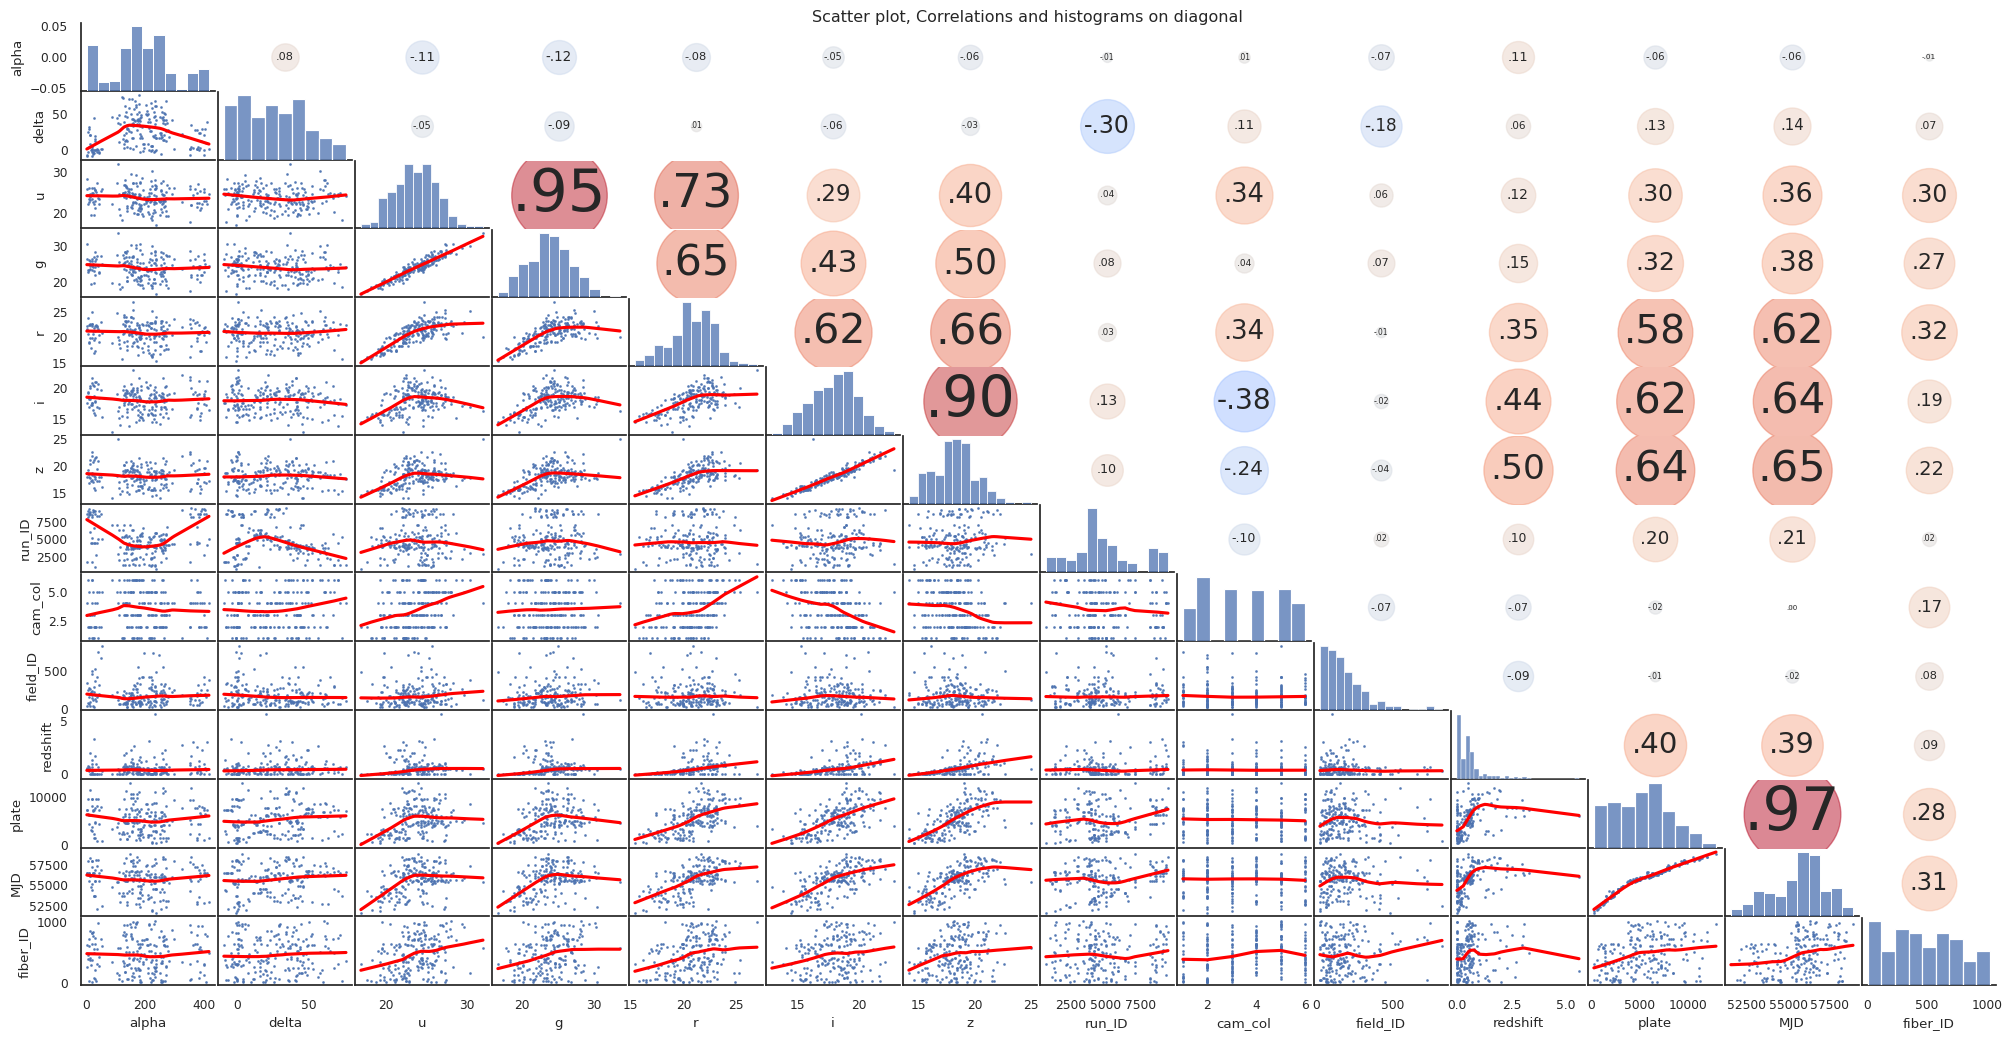

In [8]:
def ScatterCorrHist(df):
  def corrdot(*args, **kwargs):
    # credit: https://stackoverflow.com/questions/48139899
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca();
    ax.set_axis_off();
    msz = abs(corr_r) * 5000   # marker size
    fsz = abs(corr_r) * 40 + 5 # font size
    ax.scatter([.5], [.5], msz, [corr_r], alpha=0.5, cmap='coolwarm', vmin=-1, vmax=1, transform=ax.transAxes)
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction", ha='center', va='center', fontsize=fsz)

  sns.set(style='white', font_scale=.8);
  g = sns.PairGrid(df, aspect=1, diag_sharey=False);
  g.fig.set_size_inches(20,10)
  g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color':'red'}, scatter_kws={'s':1});
  g.map_diag(sns.histplot, kde_kws={'color':'black'});
  g.map_upper(corrdot);
  g.fig.suptitle("Scatter plot, Correlations and histograms on diagonal", y=1);
  _ = plt.subplots_adjust(hspace=0.02, wspace=0.02);
  _ = plt.show();

ScatterCorrHist(tXY.head(200))

In [9]:
tmr = Timer()

⏳ started. You have 60 sec. Good luck!


<hr color=green size=40>

<strong><font color=green size=5>⏳Timed Green Playground (TGP): Your ideas, code, documentation, and timer START HERE!</font></strong>

<font color=green>Students: Keep all your definitions, code, documentation in <b>TGP</b>. Modifying any code outside of TGP incurs penalties.

<font color=green><h3><b>$\alpha$. Feature engineering</b><h3>

In [10]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import KMeans
import random
import warnings
warnings.filterwarnings('ignore')

# Fix all random seeds for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# Separate train and test sets
df_train = df[df['Class'].notna()].copy()
df_test = df[df['Class'].isna()].copy()

# Remove outliers using Interquartile Range method
def remove_outliers_iqr(data, features, threshold=1.5):
    data_clean = data.copy()

    for col in features:
        Q1 = data_clean[col].quantile(0.25)
        Q3 = data_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        mask = (data_clean[col] >= lower_bound) & (data_clean[col] <= upper_bound)
        data_clean = data_clean[mask]

    return data_clean

# Apply outlier removal to photometric features and redshift
outlier_features = ['u', 'g', 'r', 'i', 'z', 'redshift']
df_train_clean = remove_outliers_iqr(df_train, outlier_features, threshold=3.0)

# Advanced feature engineering
def create_advanced_features(data):
    data = data.copy()

    # Basic color indices
    data['u_g'] = data['u'] - data['g']
    data['g_r'] = data['g'] - data['r']
    data['r_i'] = data['r'] - data['i']
    data['i_z'] = data['i'] - data['z']
    data['u_r'] = data['u'] - data['r']
    data['g_i'] = data['g'] - data['i']
    data['r_z'] = data['r'] - data['z']

    # Log transformations
    data['log_ug'] = np.log1p(data['u_g'] + 3)
    data['log_gr'] = np.log1p(data['g_r'] + 3)
    data['log_ri'] = np.log1p(data['r_i'] + 3)

    # Reciprocal tranformations
    data['inv_gr'] = 1 / (data['g_r'] + 1e-10)
    data['inv_ri'] = 1 / (data['r_i'] + 1e-10)

    # Square root transformations
    data['sqrt_ug'] = np.sqrt(np.abs(data['u_g']))
    data['sqrt_gr'] = np.sqrt(np.abs(data['g_r']))

    # Color x redshift transformations
    data['ug_x_logz'] = data['u_g'] * np.log1p(data['redshift'])
    data['gr_x_logz'] = data['g_r'] * np.log1p(data['redshift'])
    data['rz_x_sqrtz'] = data['r_z'] * np.sqrt(data['redshift'])

    # Flux-based features
    for band in ['u', 'g', 'r', 'i', 'z']:
        data[f'flux_{band}'] = 10**(-0.4 * data[band])
    data['flux_ratio_ug'] = data['flux_u'] / (data['flux_g'] + 1e-10)
    data['flux_ratio_gr'] = data['flux_g'] / (data['flux_r'] + 1e-10)
    data['flux_ratio_ri'] = data['flux_r'] / (data['flux_i'] + 1e-10)

    # Redshift features
    data['redshift_sq'] = data['redshift'] ** 2
    data['redshift_log'] = np.log1p(data['redshift'])
    data['redshift_sqrt'] = np.sqrt(data['redshift'])
    data['z_bin_low'] = (data['redshift'] < 0.1).astype(int)
    data['z_bin_high'] = (data['redshift'] >= 0.5).astype(int)

    # Statistical aggregates
    mags = data[['u', 'g', 'r', 'i', 'z']]
    data['mag_mean'] = mags.mean(axis=1)
    data['mag_std'] = mags.std(axis=1)
    data['mag_range'] = mags.max(axis=1) - mags.min(axis=1)
    data['mag_skew'] = mags.skew(axis=1)

    # Astronomical features (advanced)
    # "d_perp" - distance to the main sequence of stars on a diagram u-g vs g-r
    # Helps to differentiate stars from galaxies and quasi-stars
    data['d_perp'] = (data['g_r'] - 0.2) - 0.45 * (data['u_g'] - 1.1)

    # Color correction
    data['ug_rest_frame'] = data['u_g'] / (1 + data['redshift'])
    data['gr_rest_frame'] = data['g_r'] / (1 + data['redshift'])
    data['ri_rest_frame'] = data['r_i'] / (1 + data['redshift'])
    data['rz_rest_frame'] = data['r_z'] / (1 + data['redshift'])
    data['ur_rest_frame'] = data['u_r'] / (1 + data['redshift'])
    data['gi_rest_frame'] = data['g_i'] / (1 + data['redshift'])

    # Clean invalid values
    data = data.replace([np.inf, -np.inf], np.nan).fillna(0)
    return data

df_train_clean = create_advanced_features(df_train_clean)
df_test = create_advanced_features(df_test)

# Astrometric and meta-feature engineering
def add_cartesian_coordinates(data):
    data = data.copy()
    alpha_rad = np.deg2rad(data['alpha'])
    delta_rad = np.deg2rad(data['delta'])
    data['coord_x'] = np.cos(delta_rad) * np.cos(alpha_rad)
    data['coord_y'] = np.cos(delta_rad) * np.sin(alpha_rad)
    data['coord_z'] = np.sin(delta_rad)
    return data

def add_frequency_encoding(train_data, test_data, cat_features):
    train_data = train_data.copy()
    test_data = test_data.copy()
    for col in cat_features:
        freq_map = train_data[col].value_counts(normalize=True).to_dict()
        train_data[f'{col}_freq'] = train_data[col].map(freq_map)
        test_data[f'{col}_freq'] = test_data[col].map(freq_map).fillna(0)
    return train_data, test_data

def add_target_encoding(train_data, test_data, cat_features):
    train_data = train_data.copy()
    test_data = test_data.copy()
    class_map = {'G': 0, 'S': 1, 'Q': 2}
    train_data['_target_num'] = train_data['Class'].map(class_map)
    for col in cat_features:
        global_mean = train_data['_target_num'].mean()
        target_mean = train_data.groupby(col)['_target_num'].mean().to_dict()
        train_data[f'{col}_target'] = train_data[col].map(target_mean)
        test_data[f'{col}_target'] = test_data[col].map(target_mean).fillna(global_mean)
    train_data = train_data.drop('_target_num', axis=1)
    return train_data, test_data

df_train_clean = add_cartesian_coordinates(df_train_clean)
df_test = add_cartesian_coordinates(df_test)

cat_features = ['run_ID', 'field_ID', 'plate', 'fiber_ID']
df_train_clean, df_test = add_frequency_encoding(df_train_clean, df_test, cat_features)
df_train_clean, df_test = add_target_encoding(df_train_clean, df_test, cat_features)

def add_encoded_interactions(data):
    data = data.copy()
    for cat_col in ['run_ID', 'plate']:
        if f'{cat_col}_target' in data.columns:
            data[f'redshift_x_{cat_col}_target'] = data['redshift'] * data[f'{cat_col}_target']
        if f'{cat_col}_freq' in data.columns:
            data[f'redshift_x_{cat_col}_freq'] = data['redshift'] * data[f'{cat_col}_freq']
    return data

df_train_clean = add_encoded_interactions(df_train_clean)
df_test = add_encoded_interactions(df_test)

# Clustering features
def add_clustering_features(train_data, test_data, n_clusters=7):
    train_data = train_data.copy()
    test_data = test_data.copy()

    cluster_features = ['u', 'g', 'r', 'i', 'z', 'redshift', 'u_g', 'g_r', 'r_i']

    scaler_cluster = StandardScaler()
    X_train_cluster = scaler_cluster.fit_transform(train_data[cluster_features])
    X_test_cluster = scaler_cluster.transform(test_data[cluster_features])

    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init=10)
    train_data['cluster'] = kmeans.fit_predict(X_train_cluster)
    test_data['cluster'] = kmeans.predict(X_test_cluster)

    train_distances = kmeans.transform(X_train_cluster)
    test_distances = kmeans.transform(X_test_cluster)

    for i in range(n_clusters):
        train_data[f'dist_cluster_{i}'] = train_distances[:, i]
        test_data[f'dist_cluster_{i}'] = test_distances[:, i]

    train_data['min_cluster_dist'] = train_distances.min(axis=1)
    test_data['min_cluster_dist'] = test_distances.min(axis=1)

    return train_data, test_data

df_train_clean, df_test = add_clustering_features(df_train_clean, df_test, n_clusters=7)

def add_temporal_features(data):
    data = data.copy()
    data['mjd_year_phase'] = (data['MJD'] % 365.25) / 365.25
    data['mjd_sin'] = np.sin(2 * np.pi * data['mjd_year_phase'])
    data['mjd_cos'] = np.cos(2 * np.pi * data['mjd_year_phase'])
    data['mjd_norm'] = (data['MJD'] - data['MJD'].min()) / (data['MJD'].max() - data['MJD'].min())
    return data

df_train_clean = add_temporal_features(df_train_clean)
df_test = add_temporal_features(df_test)

def add_polynomial_features(train_data, test_data):
    train_data = train_data.copy()
    test_data = test_data.copy()

    poly_features = ['u_g', 'g_r', 'r_i', 'i_z', 'redshift_log', 'mag_std']

    poly_features = [f for f in poly_features if f in train_data.columns and f in test_data.columns]

    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)

    X_train_poly = poly.fit_transform(train_data[poly_features])
    X_test_poly = poly.transform(test_data[poly_features])

    poly_feature_names = poly.get_feature_names_out(poly_features)

    df_poly_train = pd.DataFrame(X_train_poly, index=train_data.index, columns=poly_feature_names)
    df_poly_test = pd.DataFrame(X_test_poly, index=test_data.index, columns=poly_feature_names)

    train_data = pd.concat([train_data, df_poly_train], axis=1)
    test_data = pd.concat([test_data, df_poly_test], axis=1)

    return train_data, test_data

df_train_clean, df_test = add_polynomial_features(df_train_clean, df_test)

exclude_cols = ['Class', 'alpha', 'delta', 'run_ID', 'cam_col', 'field_ID',
                'plate', 'MJD', 'fiber_ID', 'cluster']
feature_cols = [col for col in df_train_clean.columns if col not in exclude_cols]

X_train = df_train_clean[feature_cols]
y_train = df_train_clean['Class']
X_test = df_test[feature_cols]

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")


Training set: (156418, 107)
Test set: (40000, 107)


<font color=green><h3><b>$\beta$. Fit a model</b><h3>

In [11]:
# Optimized Logistic Regression model
inverse_class_map = {0: 'G', 1: 'S', 2: 'Q'}

# Optimal hyperparameters from grid search: C=5.0, class_weight=None, solver='lbfgs'
model = LR(
    C=5.0,
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1200,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

# Calculate training accuracy
y_train_pred = model.predict(X_train_scaled)
train_acc = np.mean(y_train_pred == y_train)

test_proba = model.predict_proba(X_test_scaled)

test_predictions = model.predict(X_test_scaled)

def make_submission(pred_labels, name):
    sub = pd.DataFrame({'id': df_test.index + 1, 'Class': pred_labels})
    sub.to_csv(f'{name}.csv', index=False)
    return sub
make_submission(test_predictions, "submission")


LogisticRegression(C=5.0, max_iter=1200, multi_class='multinomial', n_jobs=-1,
                   random_state=42)

,id,Class
0,1,G
1,2,Q
...,...,...
39998,39999,G
39999,40000,S


In [12]:
!kaggle competitions submit -c 25-hse-stellar -f submission.csv -m "Testing"

100% 302k/302k [00:00<00:00, 1.54MB/s]
Successfully submitted to 25hse-🌌Stellar

<font color=green><h3><b>$\epsilon$. Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Explain Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Explain elements of your preprocessing pipeline i.e. feature engineering, subsampling, clustering, dimensionality reduction, etc.</font>

<font color=green>

1. Why did you choose these elements? (Something in EDA, prior experience,...? Note: EDA is not required)
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

**Preprocessing Pipeline**

1. Fixed seeds `(RANDOM_STATE = 42)` for reproducibility.

2. Created color indices `(u_g, g_r, r_i, i_z)` to represent spectral differences.

3. Added flux features `(flux_u … flux_z)` and flux ratios `(flux_ratio_ug, flux_ratio_gr, flux_ratio_ri)` for scale-invariant brightness relations.

4. Introduced astronomical feature `d_perp` (distance from the stellar locus on u-g vs g-r) to separate stars from galaxies and quasars.

5. Computed moments statistics `(mean, std, range, skew)` to summarize brightness.

6. Applied rest-frame color correction (divide colors by 1 + redshift).

7. Generated polynomial / interaction features with `PolynomialFeatures(degree = 2)` to capture nonlinear relations.

8. Standardized all numeric features with `StandardScaler`.

**Why: these transformations reflect physical color relationships, reduce redshift effects, and make linear models expressive yet stable.**

*Effectiveness: measured by validation accuracy (best `C = 5.0` after grid search) and comparison of feature subsets.
Higher polynomial degrees or removing scaling hurt performance.*


<font color=green><h4><b>Task 2. Explain Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Explain your modeling approach, i.e. ideas you tried and why you thought they would be helpful.

1. How did these decisions guide you in modeling?
1. How do you evaluate the effectiveness of these elements?
1. What else have you tried that worked or didn't?

</font>

Final model:

```
LogisticRegression(
    multi_class='multinomial', solver='lbfgs',
    C=5.0, max_iter=1200, random_state=42)
```

*   Simple, interpretable baseline; `lbfgs `ensures stable convergence.
*   Scaling fitted on train only (no leakage).

**Rationale: keeps pipeline lightweight and reproducible while capturing nonlinearities through engineered features.**

*Evaluation: train accuracy ≈ val accuracy after tuning C; grid-search confirmed stability.
LDA/QDA were tested but overfit or assumed unrealistic covariance; PCA gave no consistent gain.*

<font color=green><h3><b>$\zeta$. References</b></h3></font>

1. Stack Overflow. (2025). Stack Overflow: Where developers learn, share, & build careers. https://stackoverflow.com
2. Yandex Education. (n.d.). Machine Learning Handbook. Retrieved October 5, 2025, from https://education.yandex.ru/handbook/ml\n,
3. NumPy Developers. (2025). NumPy documentation. https://numpy.org/doc\n

<font size=5>⌛</font> <strong><font color=green size=5>Do not exceed competition's runtime limit! Do not write code outside TGP</font></strong>
<hr color=green size=40>

In [13]:
tmr.ShowTime()    # measure Colab's runtime. Do not remove. Keep as the last cell in your notebook.

Runtime is 49 sec


<font color=green><h4><b>$\epsilon$. LLM Documentation if used</b></h4></font>

We have used [ChatGPT](https://chatgpt.com/) (GPT-5) as a technical assistant during implementation. Specifically, it helped:

1. Draft and refine the `GridSearchCV` procedure for tuning `Logistic Regression` hyperparameters (C, solver, max_iter).

2. Suggest data preprocessing patterns (e.g., structure for label smoothing, modular outlier removal, and polynomial feature generation).

3. Create visualization snippets for preliminary EDA (distribution plots, feature correlations, and color-color diagrams).

4. Verify syntax compatibility between Colab, scikit-learn, and Kaggle API commands.

The LLM provided syntax-level guidance and boilerplate structure, but model design, feature selection, and analytical decisions were made manually by the authors.
The final model choice `(LogisticRegression with C=5.0, lbfgs, max_iter=1200)`, preprocessing pipeline, and evaluation metrics were determined independently.


## 💡**Starter Ideas**

1. Tune model hyperparameters
1. Try to linear and non-linear feature normalization: shift/scale, log, divide features by features (investigate scatterplot matrix)
1. Try higher order feature interactions and polynomial features on a small subsample. Then identify key features or select key principal components. The final model can be trained on a larger or even full training sample. You can use [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the feature set
1. Do a thorough EDA: look for feature augmentations that result in linear decision boundaries between pairs of classes.
1. Evaluate predictions and focus on poorly predicted "groups":
  1. Strongest missclassifications. E.g. the model is very confident about the wrong label
  1. Evaluate predictions near decision boundaries.
1. Do scatter plots show piecewise linear shape? Can a separate linear model be used on each support, or can the pattern be linearized via transformations?
1. How are date/categorical features treated by the model? Is there a [better way](https://www.google.com/search?q=ways+to+encode+categorical+data) to encode these (perhaps, ordinal) features?
  1. E.g. you could replace codes (or groups of codes) with their frequencies, which may capture the implied "distance" or rarity between category levels.
  1. If encoding ordinal features with integers, should non-equidistant values be considered?
1. Learn astronomy domain and features: [🎦](https://www.youtube.com/results?search_query=Quasi-star), [quasi-star](https://en.wikipedia.org/wiki/Quasi-star), [star](https://en.wikipedia.org/wiki/Star), [galaxy](https://en.wikipedia.org/wiki/Galaxy), [📃](https://arxiv.org/abs/2112.02026)
